In [12]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
# Add src directory to path so we can import tailrisk
src_path = str(Path.cwd().parent / "src")
sys.path.insert(0, src_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
from scipy import stats

from tailrisk import (
    compute_log_returns,
    historical_var, historical_es, fit_normal_params, fit_t_params,
    parametric_var_normal, parametric_es_normal,
    parametric_var_t, parametric_es_t,
    fit_gpd_mle, gpd_var_es,
    kupiec_test, christoffersen_test,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# Load saved data from notebook 01 (returns already in %)
data_path = Path.cwd().parent / "data"
prices = pd.read_csv(data_path / "TSLA_prices.csv", index_col=0, parse_dates=True).squeeze()
rets = pd.read_csv(data_path / "TSLA_returns.csv", index_col=0, parse_dates=True).squeeze()

In [14]:
rets = compute_log_returns(prices)
alpha = 0.99
window = 1000  # training window length

var_hist = pd.Series(index=rets.index, dtype=float)
var_norm = pd.Series(index=rets.index, dtype=float)
var_t    = pd.Series(index=rets.index, dtype=float)
var_evt  = pd.Series(index=rets.index, dtype=float)


In [15]:
for t in range(window, len(rets)):
    window_rets = rets.iloc[t-window:t]

    # 1) Historical VaR
    var_hist.iloc[t] = historical_var(window_rets, alpha=alpha)

    # 2) Normal VaR
    mu, sigma = fit_normal_params(window_rets.values)
    var_norm.iloc[t] = parametric_var_normal(mu, sigma, alpha=alpha)

    # 3) t VaR
    df, loc, scale = fit_t_params(window_rets.values)
    var_t.iloc[t] = parametric_var_t(df, loc, scale, alpha=alpha)

    # 4) EVT VaR  (POT on loss space)
    losses_window = -window_rets
    u_evt = float(losses_window.quantile(0.975))  # 也可以 0.95 / grid search
    gpd_params_win = fit_gpd_mle(window_rets.values, u_evt)
    var_evt_loss, _ = gpd_var_es(gpd_params_win, alpha=alpha)
    var_evt.iloc[t] = var_evt_loss  # already positive loss number


In [16]:
results = []

for name, vs in [
    ("Historical", var_hist),
    ("Normal",     var_norm),
    ("Student-t",  var_t),
    ("EVT-GPD",    var_evt),
]:
    lr_uc, p_uc, n_exceed, n_total = kupiec_test(rets, vs, alpha=alpha)
    lr_cc, p_cc = christoffersen_test(rets, vs, alpha=alpha)
    results.append({
        "Model": name,
        "n_exceed": n_exceed,
        "n_total": n_total,
        "freq": n_exceed / n_total if n_total > 0 else np.nan,
        "Kupiec_LR": lr_uc,
        "Kupiec_p": p_uc,
        "Christoffersen_LR": lr_cc,
        "Christoffersen_p": p_cc,
    })

df_results = pd.DataFrame(results)
df_results


,Model,n_exceed,n_total,freq,Kupiec_LR,Kupiec_p,Christoffersen_LR,Christoffersen_p
0,Historical,33,2875,0.011478,0.605756,4.363904e-01,0.722658,0.395273
1,Normal,59,2875,0.020522,24.652804,6.864479e-07,0.450395,0.502147
2,Student-t,36,2875,0.012522,1.709927,1.909948e-01,0.511880,0.474326
3,EVT-GPD,34,2875,0.011826,0.914837,3.388342e-01,0.647458,0.421023


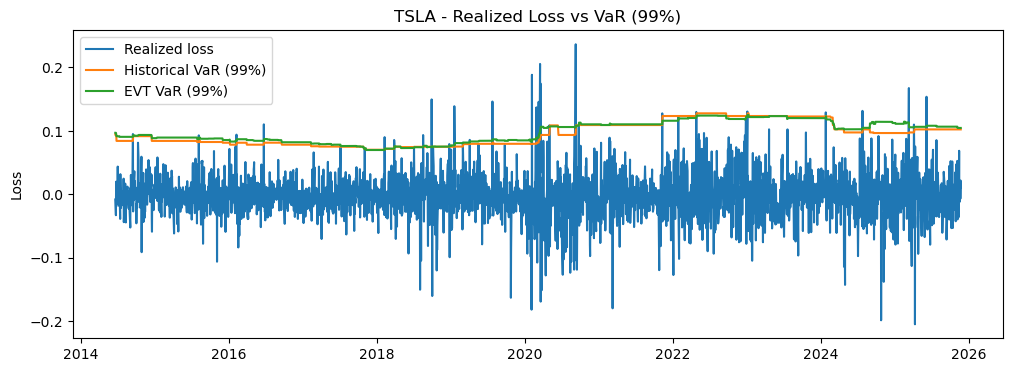

In [17]:
aligned = pd.concat(
    [rets, var_hist, var_evt],
    axis=1,
    keys=["return", "VaR_hist", "VaR_evt"]
).dropna()

plt.figure(figsize=(12, 4))
plt.plot(aligned.index, -aligned["return"], label="Realized loss")
plt.plot(aligned.index, aligned["VaR_hist"], label="Historical VaR (99%)")
plt.plot(aligned.index, aligned["VaR_evt"], label="EVT VaR (99%)")
plt.legend()
plt.title("TSLA - Realized Loss vs VaR (99%)")
plt.ylabel("Loss")
plt.show()


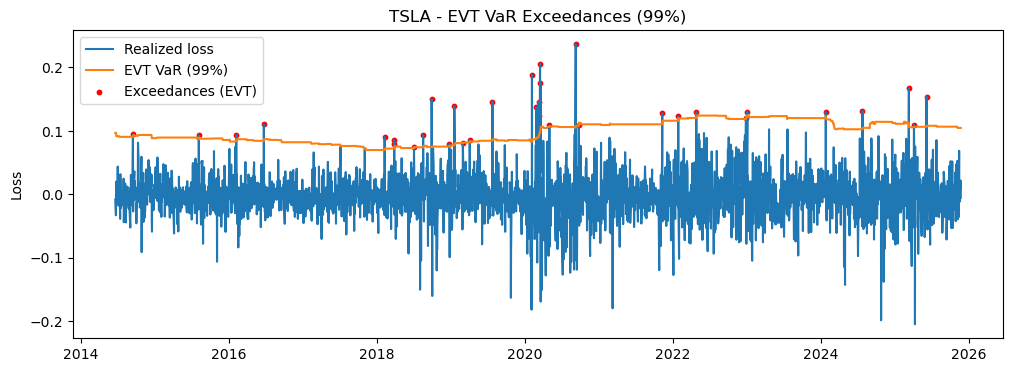

In [18]:
exceed_evt = (-aligned["return"] > aligned["VaR_evt"])

plt.figure(figsize=(12, 4))
plt.plot(aligned.index, -aligned["return"], label="Realized loss")
plt.plot(aligned.index, aligned["VaR_evt"], label="EVT VaR (99%)")

plt.scatter(
    aligned.index[exceed_evt],
    (-aligned["return"])[exceed_evt],
    marker="o", s=10, label="Exceedances (EVT)", color="red"
)
plt.legend()
plt.title("TSLA - EVT VaR Exceedances (99%)")
plt.ylabel("Loss")
plt.show()
